In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torchvision import datasets


%config InlineBackend.figure_format = 'retina'

class ViTEncoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3,
                 embed_dim=128, num_heads=4, depth=2):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2

        # Patch embedding
        self.patch_embed = nn.Conv2d(in_ch, embed_dim,
                                     kernel_size=patch_size, stride=patch_size)

        # Positional embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        # Transformer blocks
        self.blocks = nn.ModuleList([
            nn.ModuleDict({
                'norm1': nn.LayerNorm(embed_dim),
                'attn': nn.MultiheadAttention(embed_dim, num_heads, batch_first=True),
                'norm2': nn.LayerNorm(embed_dim),
                'mlp': nn.Sequential(
                    nn.Linear(embed_dim, 4 * embed_dim),
                    nn.GELU(),
                    nn.Linear(4 * embed_dim, embed_dim),
                )
            }) for _ in range(depth)
        ])

        self.final_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # --- Patchify ---
        x = self.patch_embed(x)           # [B, D, H/P, W/P]
        B, D, Hn, Wn = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, N, D]
        x = x + self.pos_embed

        # --- Transformer blocks ---
        for blk in self.blocks:
            # Self-Attention with residual
            h = blk['norm1'](x)
            attn_out, _ = blk['attn'](h, h, h)
            x = x + attn_out

            # MLP with residual
            h = blk['norm2'](x)
            mlp_out = blk['mlp'](h)
            x = x + mlp_out

        x = self.final_norm(x)
        return x, (Hn, Wn)

In [72]:
class ViTDecoder(nn.Module):
    def __init__(self, embed_dim=64, out_ch=3):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 128, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, out_ch, 1)
        )

    def forward(self, x, spatial_shape):
        B, N, D = x.shape
        Hn, Wn = spatial_shape
        x = x.transpose(1, 2).reshape(B, D, Hn, Wn)
        out = self.decoder(x)
        out = F.interpolate(out, size=(Hn * 16, Wn * 16),
                            mode='bilinear', align_corners=False)
        return out


In [73]:
class ViT_MAE(nn.Module):
    def __init__(self, img_size=224, patch_size=16, embed_dim=64, num_heads=1, depth=2):
        super().__init__()
        self.encoder = ViTEncoder(img_size, patch_size, 3, embed_dim, num_heads, depth)
        self.decoder = ViTDecoder(embed_dim, 3)

    def forward(self, x):
        z, spatial_shape = self.encoder(x)
        recon = self.decoder(z, spatial_shape)
        return recon


In [74]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = ViT_MAE(num_heads=4, embed_dim=128, depth=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def train_autoencoder(model, loader, optimizer, criterion, device, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for x_masked, y_full in loader:
            x_masked, y_full = x_masked.to(device), y_full.to(device)
            pred = model(x_masked)
            loss = criterion(pred, y_full)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item() * x_masked.size(0)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(loader.dataset):.4f}")



In [75]:
class PatchMaskedDataset(Dataset):
    def __init__(self, base_dataset, patch_size=16, mask_ratio=0.75):
        self.base_dataset = base_dataset
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]       # we don’t use labels for MAE
        C, H, W = img.shape
        assert H % self.patch_size == 0 and W % self.patch_size == 0

        # --- Split into patches ---
        h_patches = H // self.patch_size
        w_patches = W // self.patch_size
        total_patches = h_patches * w_patches

        # --- Choose patches to mask ---
        num_mask = int(total_patches * self.mask_ratio)
        mask_indices = np.random.choice(total_patches, num_mask, replace=False)

        # --- Make copy for masked version ---
        img_masked = img.clone()
        for idx_mask in mask_indices:
            r = idx_mask // w_patches
            c = idx_mask % w_patches
            y0, y1 = r * self.patch_size, (r + 1) * self.patch_size
            x0, x1 = c * self.patch_size, (c + 1) * self.patch_size
            img_masked[:, y0:y1, x0:x1] = 0.0   # zero out full patch

        return img_masked, img

In [76]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_base = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_base  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Take small subset for educational speed
from torch.utils.data import Subset
train_small = Subset(train_base, range(1000))
test_small  = Subset(test_base, range(1000))

# Wrap with patch-mask dataset
train_pmask = PatchMaskedDataset(train_small, patch_size=16, mask_ratio=0.75)
test_pmask  = PatchMaskedDataset(test_small,  patch_size=16, mask_ratio=0.75)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_pmask, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_pmask,  batch_size=8, shuffle=False)

In [77]:
def visualize_reconstruction(model, dataset, idx=0, device='cpu'):
    """Visualize one reconstruction from a masked dataset."""
    model.eval()

    x_masked, y_full = dataset[idx]
    x_masked = x_masked.unsqueeze(0).to(device)
    y_full = y_full.unsqueeze(0).to(device)

    with torch.no_grad():
        recon = model(x_masked)

    # Plot side-by-side
    plt.figure(figsize=(9, 3))
    imgs = [x_masked[0], y_full[0], recon[0]]
    titles = ["Masked", "Original", "Reconstructed"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(imgs[i].permute(1, 2, 0).cpu().clamp(0, 1))
        plt.title(titles[i])
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    
    

In [78]:
def print_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model has {total_params/1e6:.2f} million parameters")

In [79]:
for num_heads in [2, 4]:
    for embed_dim in [64, 128]:
        for depth in [2, 4]:
            print(f"ViT-MAE with {num_heads} heads and embed dim {embed_dim} and depth {depth}:")
            model = ViT_MAE(num_heads=num_heads, embed_dim=embed_dim, depth=depth).to(device)
            print_model_size(model)
            print()


ViT-MAE with 2 heads and embed dim 64 and depth 2:
Model has 0.20 million parameters

ViT-MAE with 2 heads and embed dim 64 and depth 4:
Model has 0.30 million parameters

ViT-MAE with 2 heads and embed dim 128 and depth 2:
Model has 0.59 million parameters

ViT-MAE with 2 heads and embed dim 128 and depth 4:
Model has 0.98 million parameters

ViT-MAE with 4 heads and embed dim 64 and depth 2:
Model has 0.20 million parameters

ViT-MAE with 4 heads and embed dim 64 and depth 4:
Model has 0.30 million parameters

ViT-MAE with 4 heads and embed dim 128 and depth 2:
Model has 0.59 million parameters

ViT-MAE with 4 heads and embed dim 128 and depth 4:
Model has 0.98 million parameters



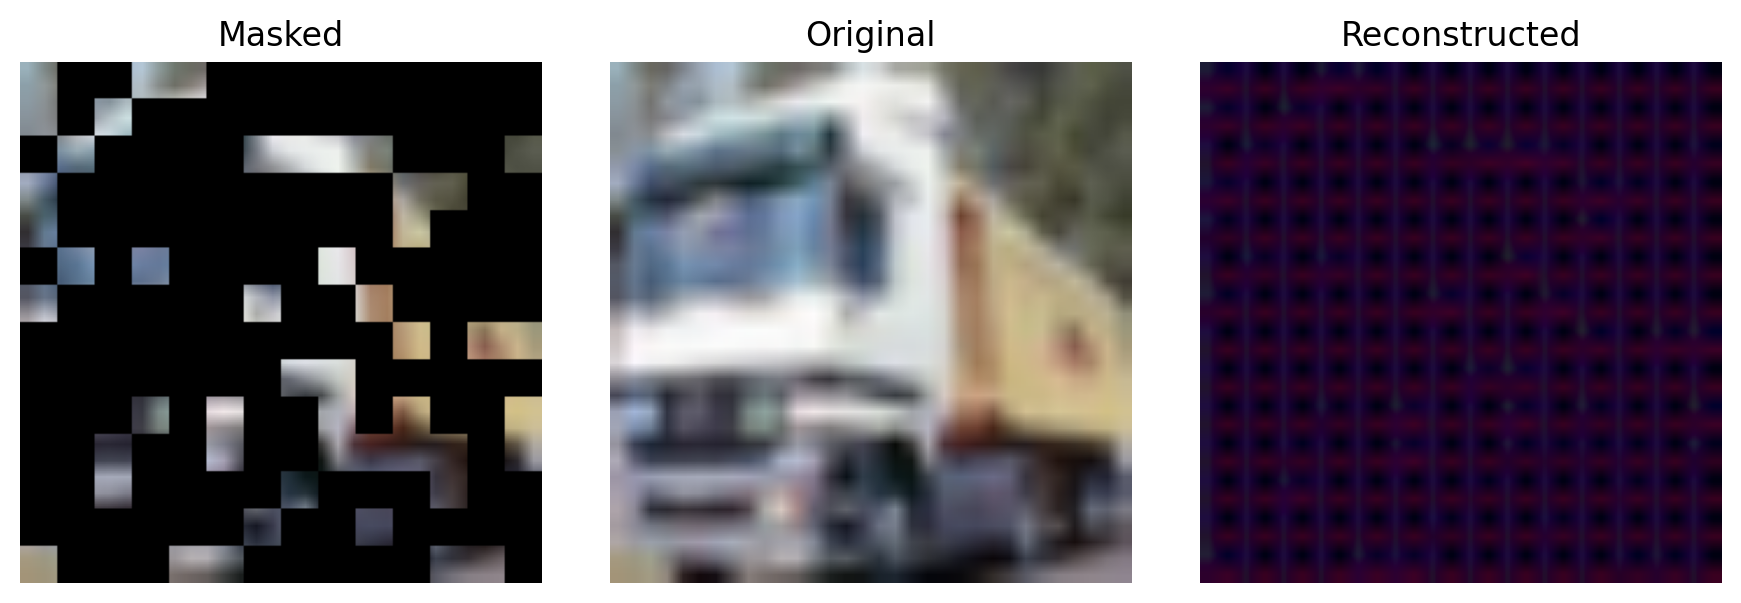

In [80]:
model = ViT_MAE(num_heads=8, embed_dim=256, depth=8).to(device)
visualize_reconstruction(model, train_pmask, idx=1, device=device)



In [81]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

train_autoencoder(model, train_loader, optimizer, criterion, device, epochs=20)

Epoch 1/20 | Loss: 0.0510
Epoch 2/20 | Loss: 0.0339
Epoch 3/20 | Loss: 0.0309
Epoch 4/20 | Loss: 0.0297
Epoch 5/20 | Loss: 0.0294
Epoch 6/20 | Loss: 0.0280
Epoch 7/20 | Loss: 0.0283
Epoch 8/20 | Loss: 0.0276
Epoch 9/20 | Loss: 0.0266
Epoch 10/20 | Loss: 0.0260
Epoch 11/20 | Loss: 0.0253
Epoch 12/20 | Loss: 0.0249
Epoch 13/20 | Loss: 0.0251
Epoch 14/20 | Loss: 0.0250
Epoch 15/20 | Loss: 0.0247
Epoch 16/20 | Loss: 0.0245
Epoch 17/20 | Loss: 0.0241
Epoch 18/20 | Loss: 0.0244
Epoch 19/20 | Loss: 0.0226
Epoch 20/20 | Loss: 0.0226


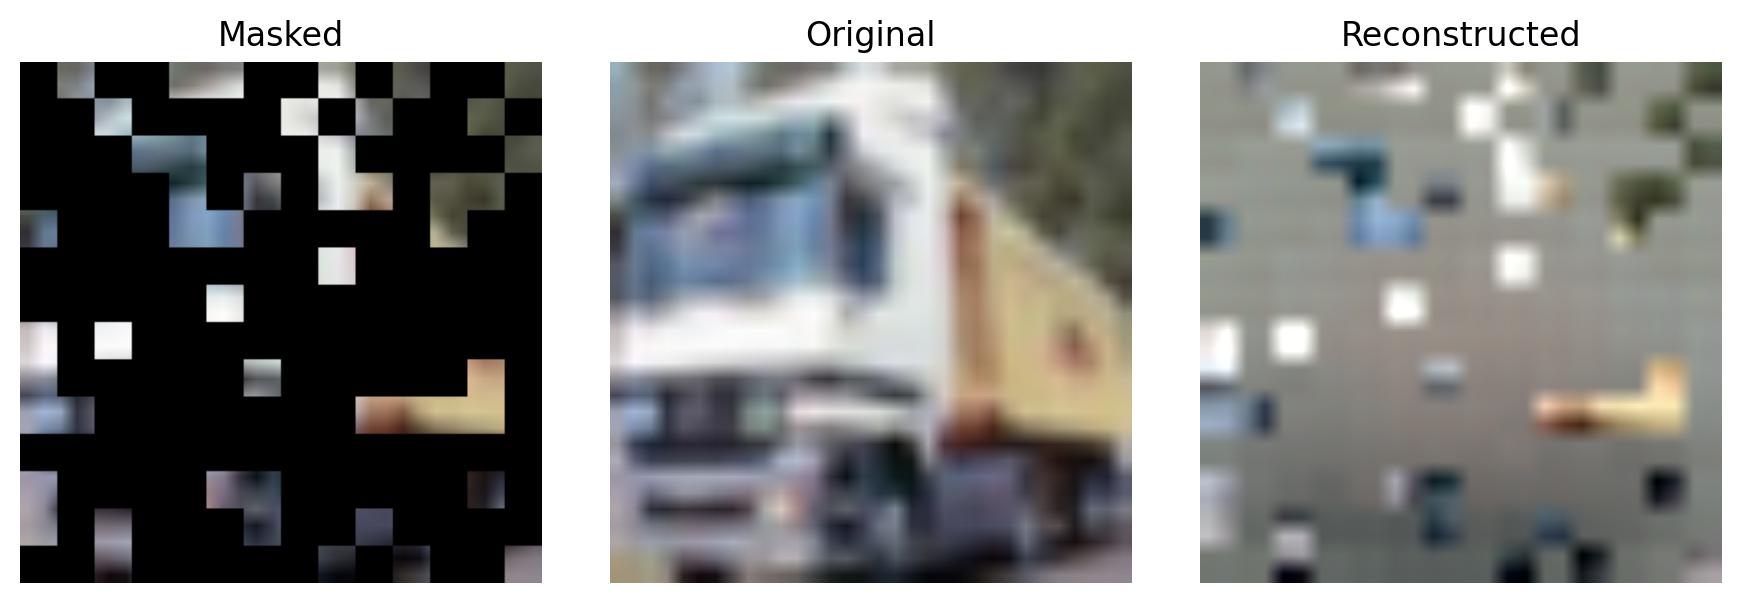

In [87]:
visualize_reconstruction(model, train_pmask, idx=1, device=device)

In [99]:
# Save MAE trained model
torch.save(model.encoder.state_dict(), "vit_mae_encoder_only.pth")


In [89]:
class ViTClassifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(encoder.embed_dim, num_classes)

    def forward(self, x):
        x, _ = self.encoder(x)
        cls = x.mean(dim=1)  # global average pooling over tokens
        return self.head(cls)


In [90]:
# Classifier for Cifar10
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT expects 224×224 input
    transforms.ToTensor(),          # Convert to tensor, scale to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # ImageNet normalization
])



# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)} images")
print(f"Test size:  {len(test_dataset)} images")

from torch.utils.data import Subset
import numpy as np

# pick 1/10th (≈5000 train, 1000 test)
train_subset_idx = np.random.choice(len(train_dataset), len(train_dataset)//10, replace=False)
test_subset_idx  = np.random.choice(len(test_dataset),  len(test_dataset)//10,  replace=False)

train_dataset_small = Subset(train_dataset, train_subset_idx)
test_dataset_small  = Subset(test_dataset,  test_subset_idx)

train_loader = DataLoader(train_dataset_small, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset_small,  batch_size=32, shuffle=False)

print(f"Reduced Train size: {len(train_dataset_small)}")
print(f"Reduced Test size:  {len(test_dataset_small)}")

Train size: 50000 images
Test size:  10000 images
Reduced Train size: 5000
Reduced Test size:  1000


In [91]:
from torch import optim

def train_and_evaluate(model, train_loader, test_loader, 
                       criterion=None, optimizer=None, 
                       device="cpu", num_epochs=20):
    """
    Train and evaluate a PyTorch model.
    Returns: train_losses, test_losses, test_accuracies
    """
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

    model.to(device)
    train_losses, test_losses, test_accs = [], [], []

    for epoch in range(num_epochs):
        # ---- Train ----
        model.train()
        total_train_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * imgs.size(0)
        epoch_train_loss = total_train_loss / len(train_loader.dataset)

        # ---- Evaluate ----
        model.eval()
        total_test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        epoch_test_loss = total_test_loss / len(test_loader.dataset)
        acc = 100 * correct / total

        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        test_accs.append(acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f} | "
              f"Test Acc: {acc:.2f}%")

    return train_losses, test_losses, test_accs

### Three configs

1. ViT without MAE pretraining
2. ViT with MAE pretraining, train entire model
3. ViT with MAE pretraining, freeze encoder, train only classifier head

In [94]:
enc = ViTEncoder(img_size=224, patch_size=16, in_ch=3, embed_dim=128, num_heads=4, depth=2)
clf_model_without_pretraining = ViTClassifier(enc).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model_without_pretraining.parameters(), lr=1e-3)

train_losses, test_losses, test_accs = train_and_evaluate(
    clf_model_without_pretraining, train_loader, test_loader,
    criterion, optimizer,
    device=device, num_epochs=6
)


Epoch 1/6 | Train Loss: 2.0778 | Test Loss: 2.0301 | Test Acc: 25.00%
Epoch 2/6 | Train Loss: 1.9576 | Test Loss: 1.9459 | Test Acc: 27.90%
Epoch 3/6 | Train Loss: 1.8606 | Test Loss: 1.9111 | Test Acc: 27.30%
Epoch 4/6 | Train Loss: 1.7660 | Test Loss: 1.7530 | Test Acc: 34.50%
Epoch 5/6 | Train Loss: 1.7020 | Test Loss: 1.7097 | Test Acc: 34.90%
Epoch 6/6 | Train Loss: 1.6283 | Test Loss: 1.6368 | Test Acc: 38.00%


In [101]:
encoder = ViTEncoder(embed_dim=128, num_heads=4, depth=2)
encoder.load_state_dict(torch.load("vit_mae_encoder_only.pth", map_location=device))
clf_model_with_pretraining = ViTClassifier(encoder).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model_with_pretraining.parameters(), lr=1e-3)

train_losses, test_losses, test_accs = train_and_evaluate(
    clf_model_with_pretraining, train_loader, test_loader,
    criterion, optimizer,
    device=device, num_epochs=6
)

Epoch 1/6 | Train Loss: 1.8423 | Test Loss: 1.8007 | Test Acc: 31.00%
Epoch 2/6 | Train Loss: 1.6832 | Test Loss: 1.7323 | Test Acc: 36.80%
Epoch 3/6 | Train Loss: 1.6167 | Test Loss: 1.6850 | Test Acc: 36.00%
Epoch 4/6 | Train Loss: 1.5744 | Test Loss: 1.6356 | Test Acc: 39.20%
Epoch 5/6 | Train Loss: 1.5500 | Test Loss: 1.6579 | Test Acc: 39.90%
Epoch 6/6 | Train Loss: 1.5035 | Test Loss: 1.5987 | Test Acc: 42.40%


In [102]:
# Now with frozen encoder
encoder = ViTEncoder(embed_dim=128, num_heads=4, depth=2)
encoder.load_state_dict(torch.load("vit_mae_encoder_only.pth", map_location=device))
clf_model_with_pretraining_frozen_encoder = ViTClassifier(encoder).to(device)

# Freeze encoder parameters
for param in clf_model_with_pretraining_frozen_encoder.encoder.parameters():
    param.requires_grad = False



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model_with_pretraining_frozen_encoder.parameters(), lr=1e-3)

train_losses, test_losses, test_accs = train_and_evaluate(
    clf_model_with_pretraining_frozen_encoder, train_loader, test_loader,
    criterion, optimizer,
    device=device, num_epochs=6
)

Epoch 1/6 | Train Loss: 1.8602 | Test Loss: 1.7881 | Test Acc: 35.00%
Epoch 2/6 | Train Loss: 1.7007 | Test Loss: 1.7534 | Test Acc: 36.60%
Epoch 3/6 | Train Loss: 1.6664 | Test Loss: 1.7444 | Test Acc: 35.50%
Epoch 4/6 | Train Loss: 1.6533 | Test Loss: 1.7403 | Test Acc: 37.00%
Epoch 5/6 | Train Loss: 1.6416 | Test Loss: 1.7370 | Test Acc: 36.40%
Epoch 6/6 | Train Loss: 1.6341 | Test Loss: 1.7299 | Test Acc: 38.20%


As expected, the model with MAE pretraining performs better than the one trained from scratch, even when the encoder is frozen. This demonstrates the effectiveness of self-supervised pretraining for improving downstream task performance.